In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 讀取 Kidney 資料
data_dir = '/content/drive/MyDrive/Kidney Cancer'
labels = ['kidney_normal', 'kidney_tumor']

# 參數設定
image_size = (128, 128)
random_state = 42
batch_size = 32
epochs = 50
learning_rate = 0.0001

In [ ]:
X, y = [], []

for label in labels:
    folder_path = os.path.join(data_dir, label)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(label)

X, y = np.array(X), np.array(y)

print(X.shape, y.shape)

(10004, 128, 128, 3) (10004,)


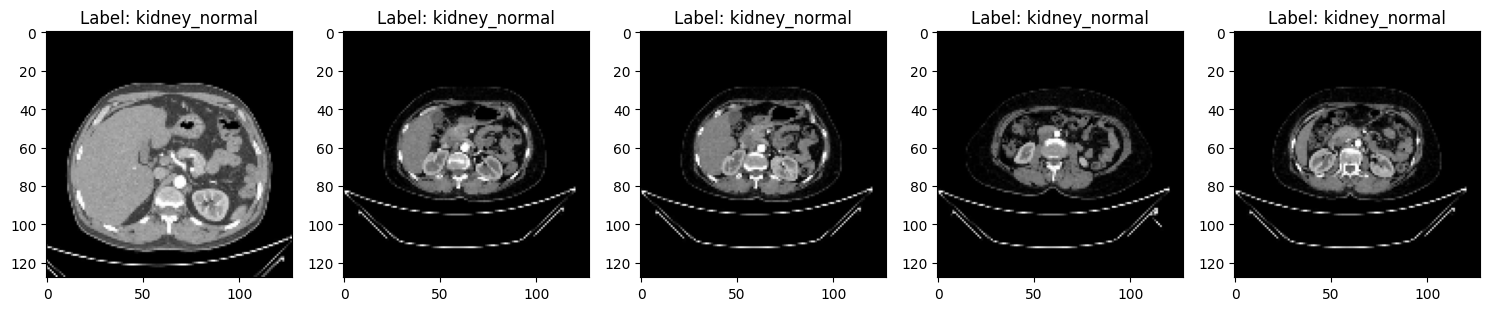

In [ ]:
# label_map = {0: 'kidney_normal', 1: 'kidney_tumor'}
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(X[i])
    # axes[i].set_title(f"Label: {label_map[y[i]]}")
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('on')

plt.tight_layout()
plt.show()

In [ ]:
# 正規化
X = X / 255.0

y = np.where(y == 'kidney_normal', 0, 1)

# 進行 one-hot 編碼
y = to_categorical(y, num_classes=2)

In [ ]:
X, y = shuffle(X,y, random_state=random_state)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

print(f"Train samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")
print(f"Test samples: {X_test.shape}")

Train samples: (7002, 128, 128, 3)
Validation samples: (1501, 128, 128, 3)
Test samples: (1501, 128, 128, 3)


In [ ]:
# 數據增強
# train_datagen = ImageDataGenerator(
#     rotation_range=5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True
# )
#
# val_test_datagen = ImageDataGenerator()
#
# train_generator = train_datagen.flow(
#     X_train, y_train,
#     batch_size=batch_size,
#     shuffle=True
# )
#
# val_generator = val_test_datagen.flow(
#     X_val, y_val,
#     batch_size=batch_size,
#     shuffle=False
# )
#
# test_generator = val_test_datagen.flow(
#     X_test, y_test,
#     batch_size=batch_size,
#     shuffle=False
# )
#
# val_images, val_labels = next(val_generator)
# print(f"Validation images batch shape: {val_images.shape}")
# print(f"Validation labels batch shape: {val_labels.shape}")
#
# test_images, test_labels = next(test_generator)
# print(f"Test images batch shape: {test_images.shape}")
# print(f"Test labels batch shape: {test_labels.shape}")

In [ ]:
# 定義 ResNet50 模型
def ResNet50Model(input_shape):
    base_model = ResNet50(include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(64)(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # x = Dense(32, kernel_regularizer=l2(0.001))(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Grid search


In [ ]:
# 初始化模型
#input_shape = (image_size[0], image_size[1], 3)
input_shape = (128, 128, 3)
learning_rate = 0.0001
model = ResNet50Model(input_shape)

In [ ]:
# 檢視模型架構
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,720,994 (90.49 MB)

 Trainable params: 133,282 (520.63 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# 訓練模型
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=epochs,
#     batch_size=batch_size
# )

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

In [ ]:
plt.figure(figsize=(10, 5))

# 訓練與驗證準確率
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 訓練與驗證損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 評估模型
# Accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
plt.subplot(1, 2, 2)
plt.plot(test_loss, label='Test Loss')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Test Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# F1-Score
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)
recall = recall_score(y_true_class, y_pred_class)
precision= precision_score(y_true_class, y_pred_class)
print(f"Test Recall: {recall:.2f}")
print(f"Test Precision: {precision:.2f}")
f1 = f1_score(y_true_class, y_pred_class)
print(f"Test F1-score: {f1:.2f}")